# Identification of corn leaf Diseases Using a deep convolutional neural network architecture by transfer learning


![alt text](https://static.country-guide.ca/wp-content/uploads/2016/04/March-III-2016-Headin_opt.jpeg)


## **Problem Statement**

The plant diseases compose a threat to global food security and smallholder farmers whose livelihoods depend mainly on agriculture and healthy crops. In developing countries, smallholder farmers produce more than 80% of the agricultural production, and reports indicate that more than fifty percent loss in crop due to pests and diseases. The world population expected to grow to more than 9.7 billion by 2050, making food security a major concern in the upcoming years. Hence, rapid and accurate methods of indentying plant diseases are needed to do the appropiate measures.

In this project, we built a Convolutional Neural Network model by transfer learning and fine-tuning to detect diseases in the corn leaves through digital images.




**Author: Luis Fernando Salazar Salinas Date: 28/10/2021**

## **Plant Village Dataset**

- The plant-Village dataset contains 39 different classes of plant leaf(healthy and unhealthy) and background images(61,486 in total)(Geetharamani & Pandian,2019). In this project,  we use the version without augmentation and just used the corn dataset, which contained four different classes (Blight, Common rust, Gray Leaf Spot, and Healthy).

In [1]:
## Import libraries
import warnings
warnings.simplefilter(action='ignore')
import os
import zipfile
from shutil import copyfile
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Load the Dataset**

- Load and extract the dataset
- Create train and test files
- Split and assign the data into train, validation and test folders(80:10:10)
- Display some images

In [2]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Load and extract the dataset
input_path = "/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease.zip"

local_zip = input_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Plant_Village_Dataset_Corn')
zip_ref.close()

In [ ]:
extrac_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/'

for set_ in ['data']:
    n_blight = len(os.listdir(extrac_path+set_ + '/Blight'))
    n_common_rust = len(os.listdir(extrac_path+set_ + '/Common_Rust'))
    n_gray_leaf_spot = len(os.listdir(extrac_path+set_ + '/Gray_Leaf_Spot'))
    n_health = len(os.listdir(extrac_path+set_ + '/Healthy'))
    print('blight images: {}, common rust images: {}, gray leaf spot images: {}, healt images:{}'.format(n_blight,
                                                                                                         n_common_rust,
                                                                                                         n_gray_leaf_spot,
                                                                                                         n_health))

blight images: 1146, common rust images: 1306, gray leaf spot images: 574, healt images:1162


In [ ]:
##Create train and test files
try:
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Healthy')

    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Healthy')

    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Healthy')
except OSError:
    print(file)

#### **Split and assign the data into train, validation and test folders(80:10:10)**

In [ ]:
#Split and assign the data into train and test files(80:20)
def split_data(SOURCE, TRAINING, VALIDATION, TESTING):

    all_files = []

    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))

    n_files = len(all_files)
    split_point_1 = round(n_files * 0.8)
    split_point_2 = round(n_files * 0.9)

    shuffled = random.sample(all_files, n_files)

    train_set = shuffled[:split_point_1]
    val_set = shuffled[split_point_1:split_point_2]
    test_set = shuffled[split_point_2:]

    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)

    for file_name in val_set:
        copyfile(SOURCE + file_name, VALIDATION + file_name)

    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

Blight_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Blight/'
Common_Rust_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Common_Rust/'
Gray_Leaf_Spot_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Gray_Leaf_Spot/'
Healthy_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Healthy/'

TRAINING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Blight/'
TRAINING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Common_Rust/'
TRAINING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Gray_Leaf_Spot/'
TRAINING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Healthy/'

VALIDATION_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Blight/'
VALIDATION_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Common_Rust/'
VALIDATION_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Gray_Leaf_Spot/'
VALIDATION_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Healthy/'

TESTING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Blight/'
TESTING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Common_Rust/'
TESTING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Gray_Leaf_Spot/'
TESTING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Healthy/'


split_data(Blight_SOURCE_DIR, TRAINING_Blight_DIR, VALIDATION_Blight_DIR, TESTING_Blight_DIR)
split_data(Common_Rust_SOURCE_DIR, TRAINING_Common_Rust_DIR, VALIDATION_Common_Rust_DIR, TESTING_Common_Rust_DIR)
split_data(Gray_Leaf_Spot_SOURCE_DIR,TRAINING_Gray_Leaf_Spot_DIR, VALIDATION_Gray_Leaf_Spot_DIR, TESTING_Gray_Leaf_Spot_DIR)
split_data(Healthy_SOURCE_DIR,TRAINING_Healthy_DIR, VALIDATION_Healthy_DIR, TESTING_Healthy_DIR)

#### **Diplay some images**

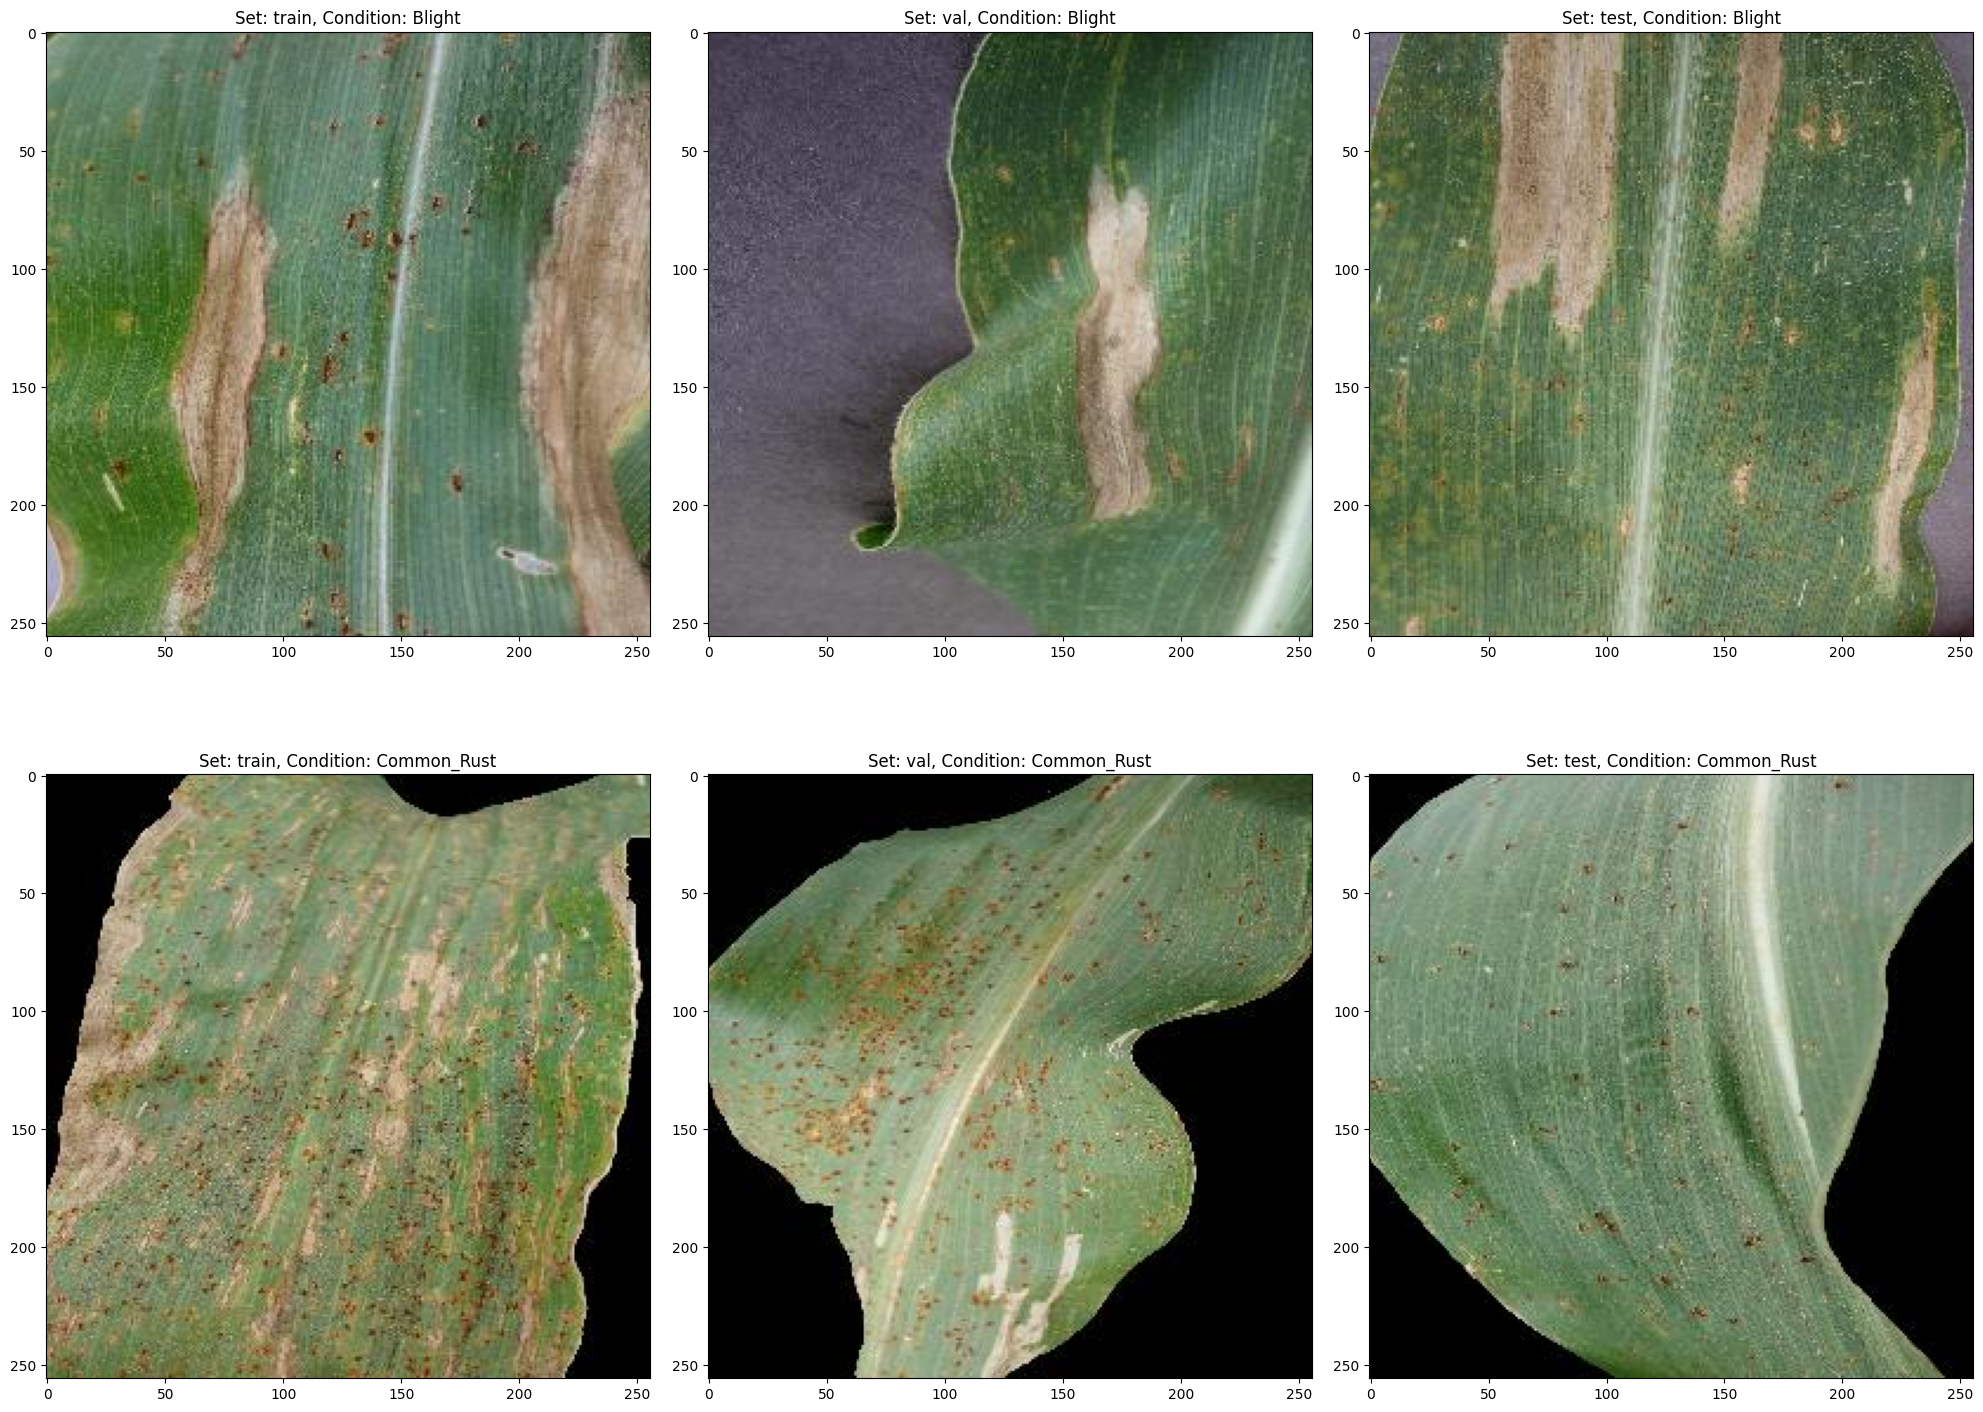

In [3]:
##
path_ = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/'

fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val', 'test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Blight/'+os.listdir(set_path+'/Blight')[0]))
    ax[i].set_title('Set: {}, Condition: Blight'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Common_Rust/'+os.listdir(set_path+'/Common_Rust')[0]))
    ax[i+3].set_title('Set: {}, Condition: Common_Rust'.format(set_))

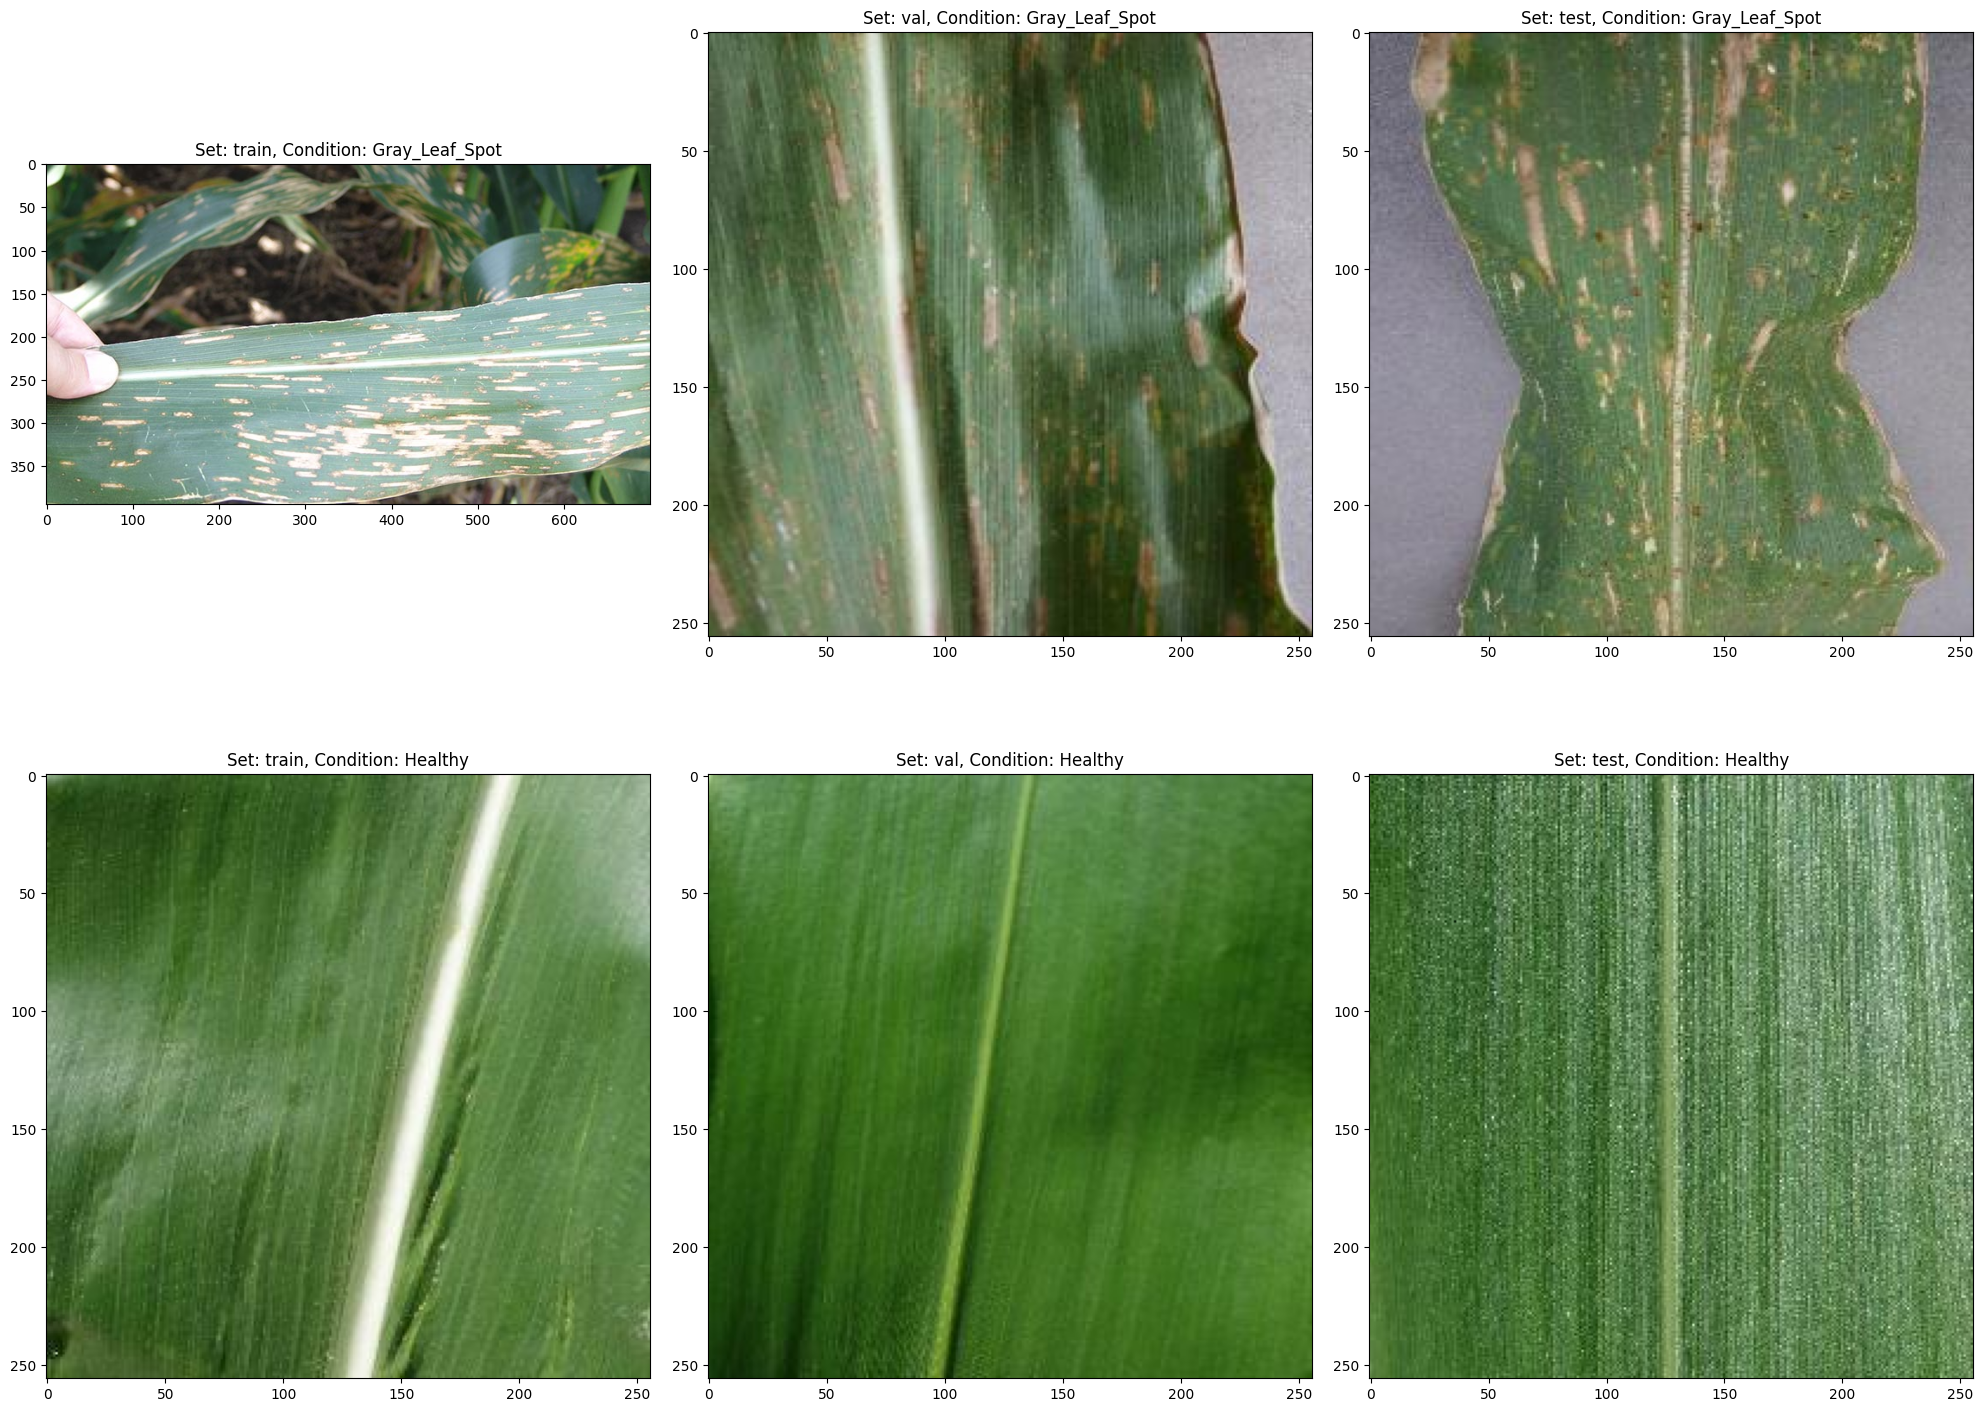

In [4]:
fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val','test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Gray_Leaf_Spot/'+os.listdir(set_path+'/Gray_Leaf_Spot')[0]))
    ax[i].set_title('Set: {}, Condition: Gray_Leaf_Spot'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Healthy/'+os.listdir(set_path+'/Healthy')[0]))
    ax[i+3].set_title('Set: {}, Condition: Healthy'.format(set_))

## **Data preprocessing**

- Split data into train and test set
- Data normalization[0,1]
- Data augmentation using saveral techniques such as:
  - image flipping
  - zoom
  - shear
  - width and height shift
  - image rotation
  - Image brightness range
  - Featurewise center
  - Featurewise std normalization
  
Note: the techniques of data augmentation were implemented using ImageDataGenerator from Keras.

In [5]:
def train_val_test_data(img_dims, batch_size):

  ## Training data
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 40,
                                       width_shift_range = .2,
                                       height_shift_range = .2,
                                       shear_range = .2,
                                       zoom_range = 0.3,
                                       horizontal_flip = True,
                                       vertical_flip=True,
                                       brightness_range=[0.5, 1.5],
                                       featurewise_center=True,
                                       featurewise_std_normalization=True,
                                       fill_mode = 'nearest',
                                   )


  ## Train generator
  train_gen = train_datagen.flow_from_directory(directory = path_ + 'train',
                                                  target_size = (img_dims, img_dims),
                                                  batch_size = batch_size,
                                                  class_mode = 'categorical',
                                                  shuffle = True)
  ## Validation Data

  validation_datagen = ImageDataGenerator(rescale = 1./255)
  ## validation generator

  val_gen = validation_datagen.flow_from_directory(directory = path_ + 'val',
                                                      target_size = (img_dims, img_dims),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical',
                                                      shuffle = True)



  return train_gen, val_gen

In [6]:
img_dims = 224
batch_size = 128

train_gen, val_gen = train_val_test_data(img_dims, batch_size)

Found 3494 images belonging to 4 classes.
Found 436 images belonging to 4 classes.


## **Modeling**

- Transfer learning (MobileNetV2 architecture)
- Fine-tuning


### **Transfer learning**
- Import MobileNetV2 model pretrained with imaginet dataset
- Freezing all layers from MobileNetV2 model
- Built a model with new top layers to classify 4 classes instead of 1000
- Training:
  - Epochs = 50
  - Adam optimizer with a 0.0001 base learning rate
- Model performance

In [7]:
## Choose a device type (CPU or GPU)
devices = tf.config.list_physical_devices('GPU')
print(devices[0])

## Name divice
name_gpu = "GPU:0"

## Define my strategy like One Device Strategy
strategy = tf.distribute.OneDeviceStrategy(device=name_gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


#### **CNN-MobileNetV2 model**

- MobileNetV2 is a convolutional neural network architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers. The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. As a whole, the architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers.

![MobilenetV2 Model](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_10.37.14_PM.png)

MobileNet architecture

In [8]:
def mobilenetv2():

  mobilenet_m = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_dims,img_dims,3),
                                                               include_top = False,
                                                               weights = 'imagenet'
                                                               )
  x = mobilenet_m.trainable = False
  x = mobilenet_m.output

  x = GlobalAveragePooling2D()(x)
  out = Dense(4,activation='softmax')(x)

  model = Model(inputs = mobilenet_m.inputs, outputs = out)

  model.summary()

  return model

In [9]:
with strategy.scope():

  mobilenetv2_model = mobilenetv2()
  mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = .0001),metrics = ['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### **Train the MobileNetV2 model**

In [12]:
epochs_1 = 50
# history_1 = mobilenetv2_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
#                                epochs=epochs_1, validation_data=(val_gen),
#                                validation_steps=val_gen.samples // batch_size
#
from math import ceil

steps_per_epoch = ceil(train_gen.samples / batch_size)
validation_steps = ceil(val_gen.samples / batch_size)

history_1 = mobilenetv2_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_1,
    validation_data=val_gen,
    validation_steps=validation_steps
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 501s 18s/step - accuracy: 0.1757 - loss: 2.3856 - val_accuracy: 0.3734 - val_loss: 1.4294
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.3426 - loss: 1.4155 - val_accuracy: 0.5292 - val_loss: 1.0815
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 1.0580
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5129 - loss: 1.1127 - val_accuracy: 0.7208 - val_loss: 0.8577
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7175 - val_loss: 0.8932
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6319 - loss: 0.9470 - val_accuracy: 0.7208 - val_loss: 0.8089
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7565 - val_loss: 0.7652
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7061 - loss: 0.8257 - va

#### **MobileNetV2 model performance**
- loss and accuracy plot
- Evaluation with the validation set
- Evaluation metrics:
 - Accuracy


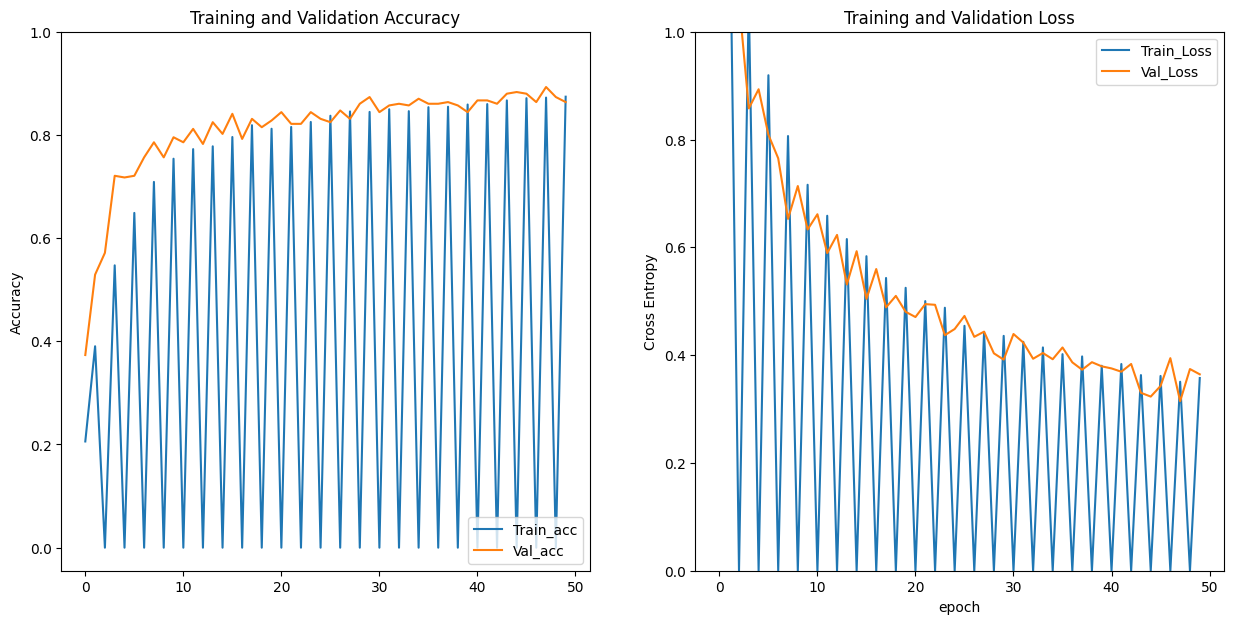

In [13]:
### Loss and accuracy plot
acc_mob = history_1.history['accuracy']
val_acc_mob = history_1.history['val_accuracy']

loss_mob = history_1.history['loss']
val_loss_mob = history_1.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_Loss')
plt.plot(val_loss_mob, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
result_eval = mobilenetv2_model.evaluate(val_gen, verbose =0)

for metric, eval in zip(mobilenetv2_model.metrics_names, result_eval):
  print(metric + ': {:.3}'.format(eval))

loss: 0.341
compile_metrics: 0.876


### **Fine-tuning the model**
- Un-freeze the top layers of MobileNetV2 model
- training:
  - Total epochs = 75
  - Adam optimazer with a low learning rate (base_learning_rate/10) to avoid the overfitting

In [ ]:
## Unfreezing layers
mobilenetv2_model.trainable = True

In [15]:
## Fine-tuning
## number of layer in the pre-trained model
print('Number of layer in the pre-trained model:{}'.format(len(mobilenetv2_model.layers)))
fine_tune_at = 100

for layer in mobilenetv2_model.layers[:fine_tune_at]:
  layer.trainable = False
print(f"Trainable Layers: {len(mobilenetv2_model.trainable_variables)}")

Number of layer in the pre-trained model:156
Trainable Layers: 2


In [16]:
with strategy.scope():

  mobilenetv2_model.summary()
  mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001/10),metrics = ['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,273,358 (8.67 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 10,250 (40.04 KB)

In [20]:
## Training
# fine_tune_epochs = 25
# total_epochs = epochs_1 + fine_tune_epochs

# history_fine = mobilenetv2_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
#                                             epochs=total_epochs,
#                                             initial_epoch = history_1.epoch[-1],
#                                             validation_data=(val_gen),
#                                             validation_steps=val_gen.samples // batch_size,
#                                     )


from math import ceil

# Calculate the correct steps per epoch and validation steps
steps_per_epoch = ceil(train_gen.samples / batch_size)
validation_steps = ceil(val_gen.samples / batch_size)

# Perform fine-tuning
fine_tune_epochs = 25
total_epochs = len(history_1.epoch) + fine_tune_epochs  # len(history_1.epoch) = 50

history_fine = mobilenetv2_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=total_epochs,
    initial_epoch=len(history_1.epoch),  # Start fine-tuning after the initial training
    validation_data=val_gen,
    validation_steps=validation_steps,
)


Epoch 51/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8741 - loss: 0.3338 - val_accuracy: 0.8734 - val_loss: 0.3536
Epoch 52/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8643 - loss: 0.3617 - val_accuracy: 0.8701 - val_loss: 0.3506
Epoch 53/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8766 - val_loss: 0.3339
Epoch 54/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8788 - loss: 0.3377 - val_accuracy: 0.8766 - val_loss: 0.3460
Epoch 55/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8799 - val_loss: 0.3368
Epoch 56/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8759 - loss: 0.3387 - val_accuracy: 0.8799 - val_loss: 0.3174
Epoch 57/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8831 - val_loss: 0.3344
Epoch 58/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8589 - loss: 0.362

In [21]:
# print(history_1.epoch)

#### **Fine-tuning model performance**
- loss and accuracy plot
- Evaluate with the validation set
- Metrics:
 - Accuracy


In [22]:
acc_mob += history_fine.history['accuracy']
val_acc_mob += history_fine.history['val_accuracy']

loss_mob += history_fine.history['loss']
val_loss_mob += history_fine.history['val_loss']


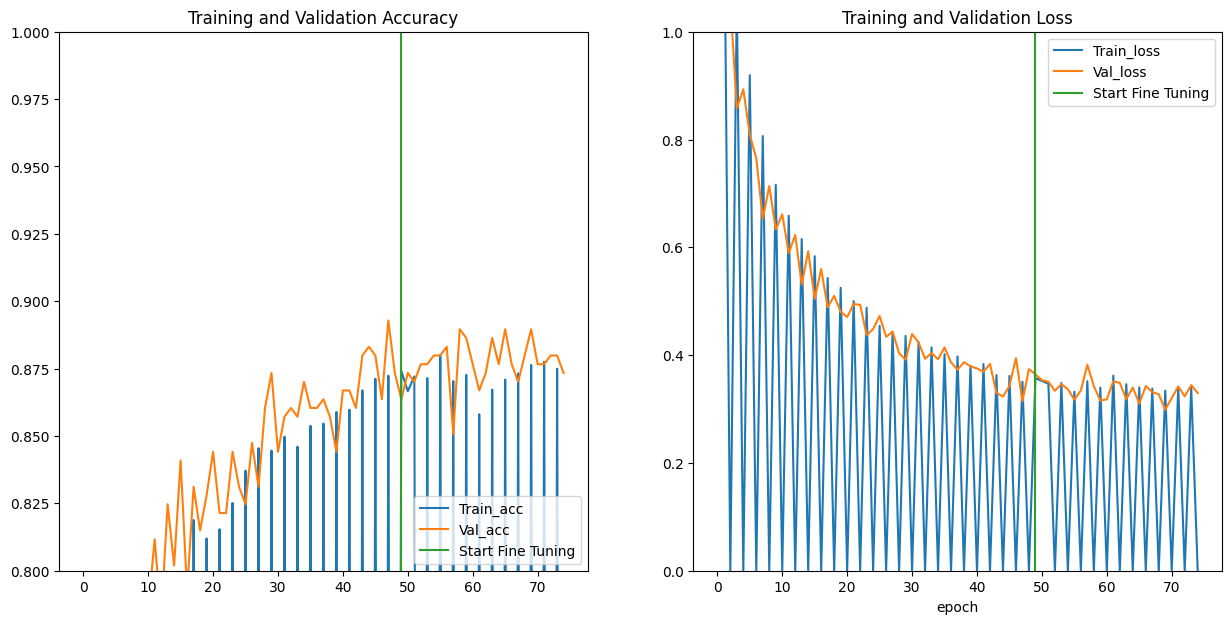

In [23]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.ylim([0.8, 1])
plt.plot([epochs_1-1,epochs_1-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_loss')
plt.plot(val_loss_mob, label='Val_loss')
plt.ylim([0, 1.0])
plt.plot([epochs_1-1,epochs_1-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
result_eval_f = mobilenetv2_model.evaluate(val_gen, verbose =0)

for metric_, eval_ in zip(mobilenetv2_model.metrics_names, result_eval_f):
  print(metric_ + ': {:.3}'.format(eval_))

loss: 0.33
compile_metrics: 0.878


##### **Observations**

- The initial model with the transfer learning technique reaches a good performance(accuracy = 0.87).

- Unfreezing some layers (fine-tuning) give more performance to the model, reaching an accuracy = 0.92 and loss = 0.21 with the validation set

### **Model Evaluation with the test set**

In [34]:
## Import the test set
input_test = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test'
labels = os.listdir(input_test)
# def get_data(data_dir):
#     data = []
#     for label in labels:
#         path = os.path.join(data_dir, label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
#                 resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
#                 data.append([resized_arr, class_num])
#             except Exception as e:
#                 print(e)
#     return np.array(data)

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                # Read image and convert BGR to RGB
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                if img_arr is None:
                    print(f"Warning: Unable to read image {os.path.join(path, img)}")
                    continue
                # Resize image
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims))
                # Append image and label
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing file {os.path.join(path, img)}: {e}")
    return data  # Keep as list to avoid NumPy conversion issues

# Reload test data
test_set_ = get_data(input_test)

# Extract features and labels
X_test, y_test = zip(*test_set_)
X_test = np.array(X_test) / 255.0  # Normalize pixel values
y_test = np.array(y_test)


In [33]:
# test_set_ = get_data(input_test)

# ## X and y test
# X_test, y_test = [],[]
# for feature, labels in test_set_:
#   X_test.append(feature)
#   y_test.append(labels)
# ## Convert the data in arrays
# X_test = np.array(X_test) / 255
# y_test = np.array(y_test)

In [35]:
## Prediction
y_pred = np.argmax(mobilenetv2_model.predict(X_test), axis = -1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step


Accuracy: 0.886%


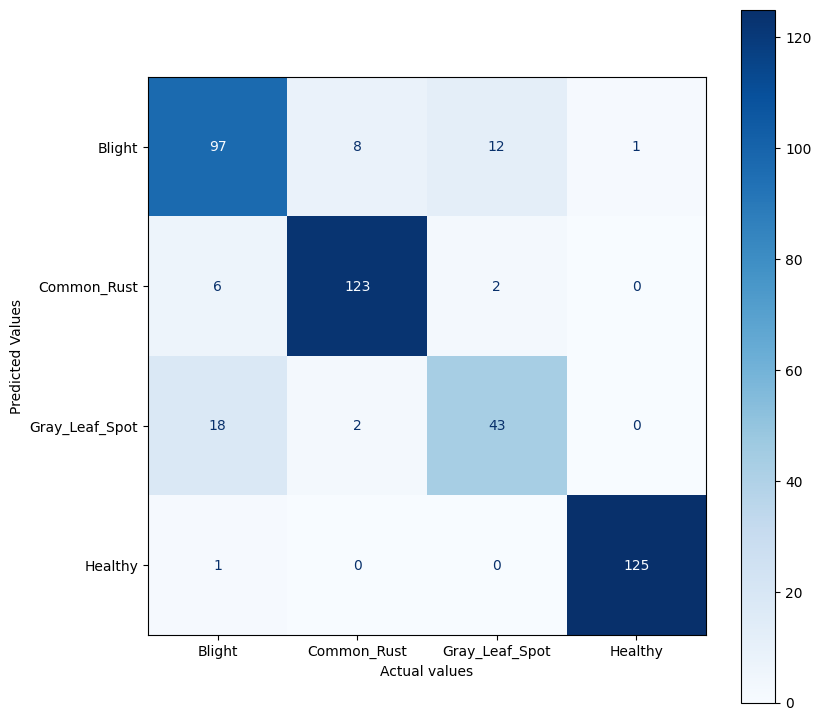

In [36]:
from sklearn.metrics import accuracy_score

#print("CONFUSION MATRIX ------------------------------")
fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
ax.xaxis.set_ticklabels(["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"])
ax.yaxis.set_ticklabels(["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"])

## Accuracy and F1-Score
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

### **Final Observations**

- In general, the model reaches quite good performance with the test set, achieving an Accuracy of 94% .

- By analysing the Confusion Matrix, we can see that the model is so good at identifying Healthy leaf images (116 out of 116) and Common Rust leaf image ( 127 out of 129) with 100% and 98.44%  images correctly classified repeclty. On the other hand, the model with respect the other classes reached a performance aceptable, with 92.3% images correctly classified for Blight leaf  and 84.6% for Grey leaf spot.

### **Save the MobileNet model**

In [31]:
# ## Save model in HDF5 format
# export_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/model_mobnetv2'
# mobilenetv2_model.save(export_path)#export_path

In [29]:
export_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/model_mobnetv2.h5'
mobilenetv2_model.save(export_path)


In [30]:
export_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/Mymodel_mobnetv2.keras'
mobilenetv2_model.save(export_path)


In [39]:
!pip install tf-keras-vis matplotlib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.6 MB/s eta 0:00:00


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_test_data(img_dims, batch_size, test_path):
    """
    Creates a test data generator for evaluating the model.

    Args:
        img_dims (int): Dimensions to resize images to (img_dims x img_dims).
        batch_size (int): Number of images per batch.
        test_path (str): Path to the test dataset directory.

    Returns:
        test_gen: A generator for the test dataset.
    """
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Test generator
    test_gen = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Do not shuffle for test data
    )
    return test_gen



In [46]:
# Define path to the test dataset
test_path =  path_+'test'  # Ensure 'test/' exists within your dataset structure

# Create test generator
test_gen = create_test_data(img_dims, batch_size, test_path)

# Verify test generator
print(f"Test samples: {test_gen.samples}")

Found 438 images belonging to 4 classes.
Test samples: 438


In [40]:
def tensor_to_image(tensor):
    """
    Converts a TensorFlow tensor to a NumPy array for visualization.
    """
    tensor = tensor.numpy()  # Convert to NumPy
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    tensor = tensor * std + mean  # Un-normalize
    tensor = np.clip(tensor, 0, 1)  # Clip values to [0, 1]
    return tensor


In [41]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import pyplot as plt
import numpy as np

# Grad-CAM++ function
def gradcamplusplus_visualization(model, image_batch, labels, class_names):
    """
    Applies Grad-CAM++ to visualize activations for DenseNet.
    """
    gradcam = GradcamPlusPlus(model)

    # Define the score function for the target class
    score = CategoricalScore(labels)

    # Compute Grad-CAM++
    cam = gradcam(score, image_batch)

    # Visualize the results
    for i in range(len(image_batch)):
        heatmap = cam[i]
        img = tensor_to_image(image_batch[i])
        plt.figure(figsize=(10, 5))

        # Overlay Grad-CAM++ heatmap on the image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.imshow(heatmap, cmap='jet', alpha=0.4)  # Overlay heatmap
        plt.axis('off')
        plt.title(f"Class: {class_names[labels[i]]}")

        # Show prediction probabilities
        plt.subplot(1, 2, 2)
        pred = model.predict(image_batch[i:i+1])
        plt.bar(range(len(class_names)), pred[0], color='gray')
        plt.bar(labels[i], pred[0][labels[i]], color='green')  # True class
        plt.xticks(range(len(class_names)), class_names, rotation=45)
        plt.title("Prediction Probabilities")
        plt.show()


In [3]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

def gradcamplusplus_visualization(model, image_batch, label_indices, class_names):
    gradcam = GradcamPlusPlus(model)

    # Define the score function for the target classes
    score = CategoricalScore(label_indices)

    # Compute Grad-CAM++
    cam = gradcam(score, image_batch)

    # Visualize Grad-CAM++ results
    for i in range(len(image_batch)):
        heatmap = cam[i]
        img = tensor_to_image(image_batch[i])
        plt.figure(figsize=(10, 5))

        # Grad-CAM++ heatmap overlay
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.imshow(heatmap, cmap='jet', alpha=0.4)
        plt.axis('off')
        plt.title(f"True: {class_names[label_indices[i]]}")

        # Prediction probabilities
        plt.subplot(1, 2, 2)
        pred = model.predict(image_batch[i:i+1])
        plt.bar(range(len(class_names)), pred[0], color='gray')
        plt.bar(label_indices[i], pred[0][label_indices[i]], color='green')  # True class
        plt.xticks(range(len(class_names)), class_names, rotation=45)
        plt.title("Prediction Probabilities")
        plt.show()


In [53]:
# Example usage


# image_batch, label_batch = next(iter(test_dataset))  # Fetch a batch of test images
# gradcamplusplus_visualization(mobilenetv2_model, image_batch, label_batch.numpy(), class_names)

from tf_keras_vis.utils.scores import CategoricalScore


# Retrieve class names from the train generator
class_names = list(train_gen.class_indices.keys())
print("Class names:", class_names)

# Fetch a batch of test data
image_batch, label_batch = next(iter(test_gen))

# Perform Grad-CAM++ visualization
# gradcamplusplus_visualization(mobilenetv2_model, image_batch, label_batch, class_names)

# Convert labels to class indices
if len(label_batch.shape) > 1:  # Check if one-hot encoded
    label_indices = np.argmax(label_batch, axis=1).tolist()
else:
    label_indices = label_batch.tolist()  # Already indices

# Grad-CAM++ visualization
gradcamplusplus_visualization(mobilenetv2_model, image_batch, label_indices, class_names)



Class names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


ResourceExhaustedError: Exception encountered when calling ReLU.call().

[1m{{function_node __wrapped__Relu6_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[128,7,7,960] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Relu6] name: [0m

Arguments received by ReLU.call():
  • inputs=tf.Tensor(shape=(128, 7, 7, 960), dtype=float32)

In [57]:
path_

'/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/'

In [54]:
# Fetch a smaller batch
image_batch, label_batch = next(iter(test_gen))
image_batch = image_batch[:16]  # Use a smaller batch size (e.g., 16 images)
label_indices = label_indices[:16]  # Match the batch size

# Perform Grad-CAM++ visualization
gradcamplusplus_visualization(mobilenetv2_model, image_batch, label_indices, class_names)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [56]:
# Ensure the image batch is on the correct device
image_batch = tf.convert_to_tensor(image_batch)  # Explicit conversion to TensorFlow tensor
label_indices = tf.convert_to_tensor(label_indices)  # Convert labels to TensorFlow tensor


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [55]:
with tf.device('/GPU:0'):  # Force GPU usage
    gradcamplusplus_visualization(mobilenetv2_model, image_batch, label_indices, class_names)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [58]:
# Fetch one image and label
image_batch, label_batch = next(iter(test_gen))
single_image = image_batch[0:1]  # Take the first image
single_label = label_batch[0:1]  # Take the corresponding label

print(f"Single image shape: {single_image.shape}")
print(f"Single label shape: {single_label.shape}")


Single image shape: (1, 224, 224, 3)
Single label shape: (1, 4)


In [59]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore

# Define Grad-CAM++ function
gradcam = GradcamPlusPlus(mobilenetv2_model)

# Convert one-hot label to index (if necessary)
if len(single_label.shape) > 1:  # Check if one-hot encoded
    single_label_index = tf.argmax(single_label, axis=1).numpy()[0]
else:
    single_label_index = single_label[0]

# Compute Grad-CAM++
score = CategoricalScore(single_label_index)
heatmap = gradcam(score, single_image)  # Single image only

print(f"Heatmap shape: {heatmap.shape}")


ResourceExhaustedError: Exception encountered when calling Conv2D.call().

[1m{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1,3,225,225] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D][0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)

In [6]:
import tensorflow as tf

with tf.device('/GPU:0'):  # Force CPU usage
    gradcamplusplus_visualization(mobilenetv2_model, image_batch, label_indices, class_names)


NameError: name 'mobilenetv2_model' is not defined